In [ ]:
### Load in the data 

In [2]:
import pandas as pd
training_data = pd.read_parquet('/Users/sowatson/dev/py-archeology/training.parquet')
training_data.sample(10)

Category  \
18792              misc.forsale   
7819                  sci.crypt   
1633                  rec.autos   
14943        talk.politics.guns   
2130      comp.sys.mac.hardware   
12319             comp.graphics   
5457    comp.os.ms-windows.misc   
13698  comp.sys.ibm.pc.hardware   
8115                    sci.med   
2460      comp.sys.mac.hardware   

                                                    Text  
18792  \n   Take Everything for $210\n\n\nTurboGrafx-...  
7819   In article <3702.204.uupcb@ssr.com>, dick.zeit...  
1633   In article <1qmq7tINN9l@tamsun.tamu.edu> dlb54...  
14943  In article <C5uCHu.FFn@cbnews.cb.att.com> lvc@...  
2130    aw@camcon.co.uk (Alain Waha) writes:\n\n   >>...  
12319  Within a few months, I'll be looking for a job...  
5457   In article <1993Apr15.180633.3437@trintex.uucp...  
13698  ----------------------------------------------...  
8115   In article <1993Apr5.165716.59@immunex.com>, r...  
2460   \nTry MaxAppleZoom ( a shareware init ) if you...

We want to transform each of the messages into a numeric vector. One way to do this would be to associate a space in a bit vector with every possible word. We could set each bit to `True` or `1` if the corresponding word appears in that message, and `0` or `False` otherwise. In practice this is not practical because of the huge memory requirements. Instead we use a 'hashing vectoriser' which _hashes_ the words to vectors of a fixed, finite number of bits. 

You can see that many of the messages contain non-standard words or character strings such as email addresses. It is common practice to ignore such words during the feature engineering stage. We do this by setting a 'token_pattern' parameter to ensure that only standard words are hashed. 

We also want to remove any 'stop words' from the text. We do this by setting `stop_words='english'`.


In [4]:
from sklearn.feature_extraction.text import HashingVectorizer
BUCKETS=2048

hv = HashingVectorizer(norm=None, token_pattern='(?u)\\b[A-Za-z]\\w+\\b', stop_words ='english', n_features=BUCKETS, alternate_sign = False)
hv
hvcounts = hv.fit_transform(training_data["Text"])
hvcounts

<13947x2048 sparse matrix of type '<class 'numpy.float64'>'
	with 1236563 stored elements in Compressed Sparse Row format>

Let's use term frequency-inverse document frequency, or tf-idf, to generate feature vectors. Tf-idf is commonly used to summarise text data, and it aims to capture how important different words are within a set of documents. Tf-idf combines a normalized word count (or term frequency) with the inverse document frequency (or a measure of how common a word is across all documents) in order to identify words, or terms, which are 'interesting' within the document, with respect to the set of documents. 

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
hvdf_tfidf = tfidf_transformer.fit_transform(hvcounts)
hvdf_tfidf

<13947x2048 sparse matrix of type '<class 'numpy.float64'>'
	with 1236563 stored elements in Compressed Sparse Row format>

### Visualise

In [6]:
import sklearn.decomposition

DIMENSIONS = 2

pca2 = sklearn.decomposition.TruncatedSVD(DIMENSIONS)
pca_a = pca2.fit_transform(hvdf_tfidf)

In [7]:
pca_df = pd.DataFrame(pca_a, columns=["x", "y"])
pca_df.sample(10)

x         y
12170  0.245778  0.034299
11422  0.315631 -0.043972
10090  0.121429  0.156066
12334  0.267605 -0.081916
13598  0.161052 -0.010064
12129  0.291294 -0.028954
4061   0.114302  0.023596
10175  0.137206  0.079771
8998   0.122494  0.066483
10973  0.229306 -0.090499

In [8]:
plot_data = pd.concat([training_data.reset_index(), pca_df], axis=1)

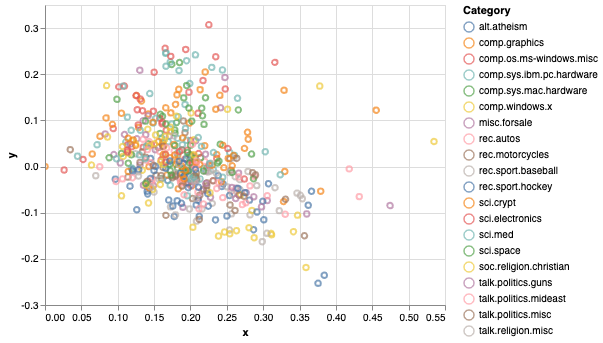

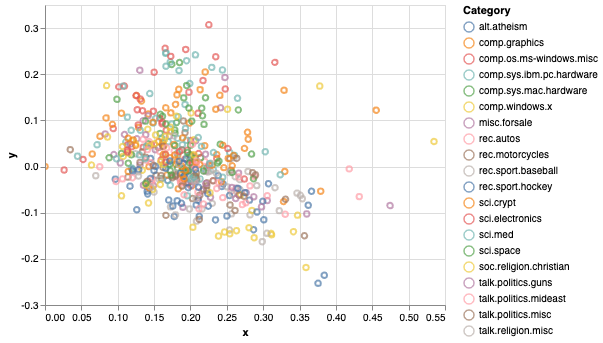

In [14]:
import altair as alt

alt.renderers.enable('notebook')
alt.Chart(plot_data.sample(2000)).encode(x="x", y="y", color="Category").mark_point().interactive()

In [ ]:
#No structure. Why?

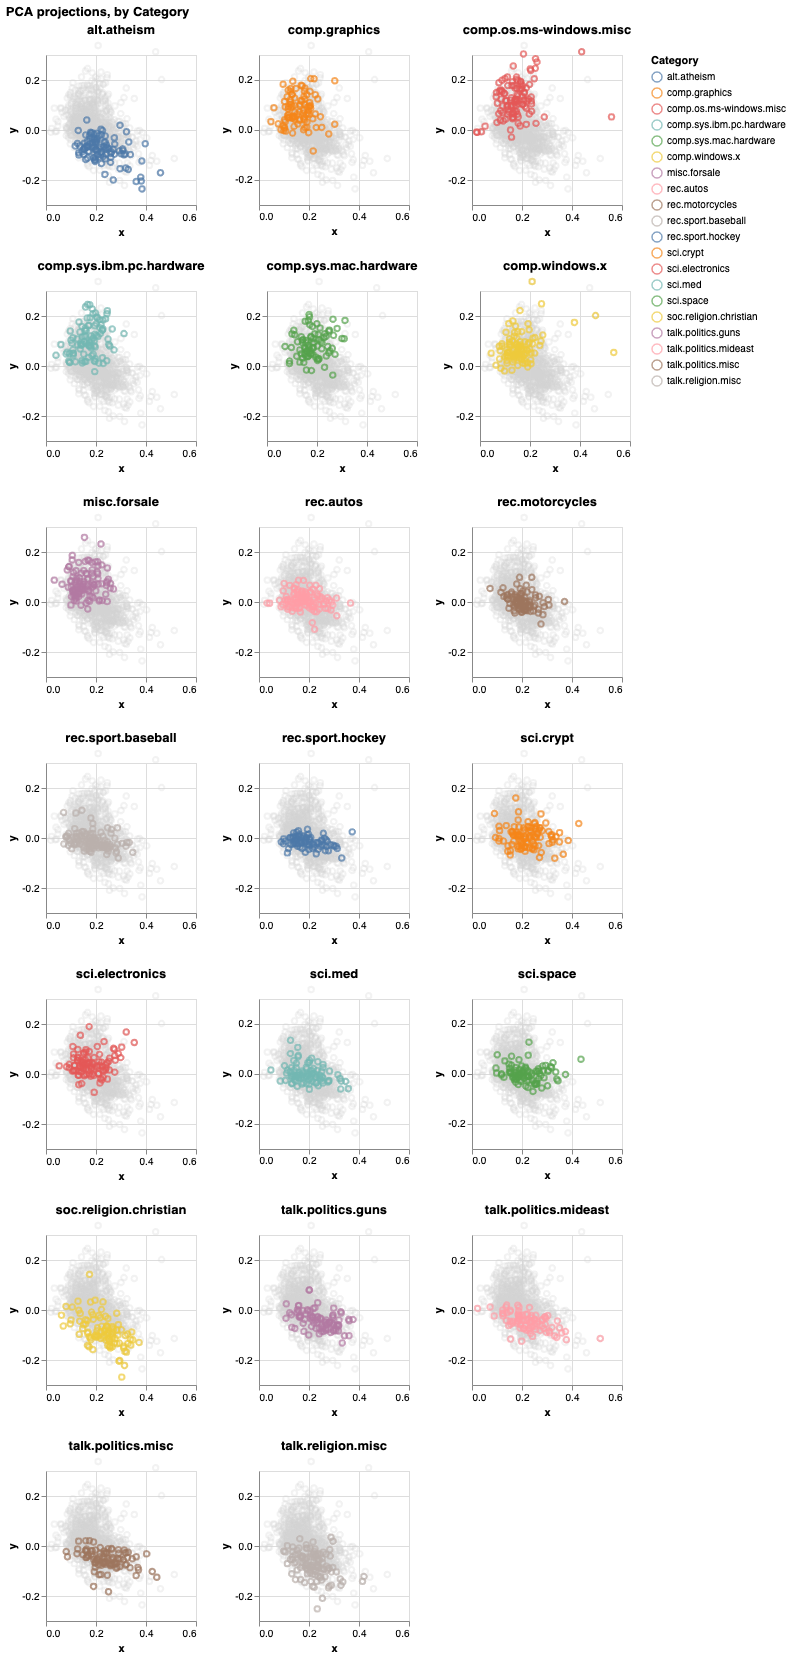

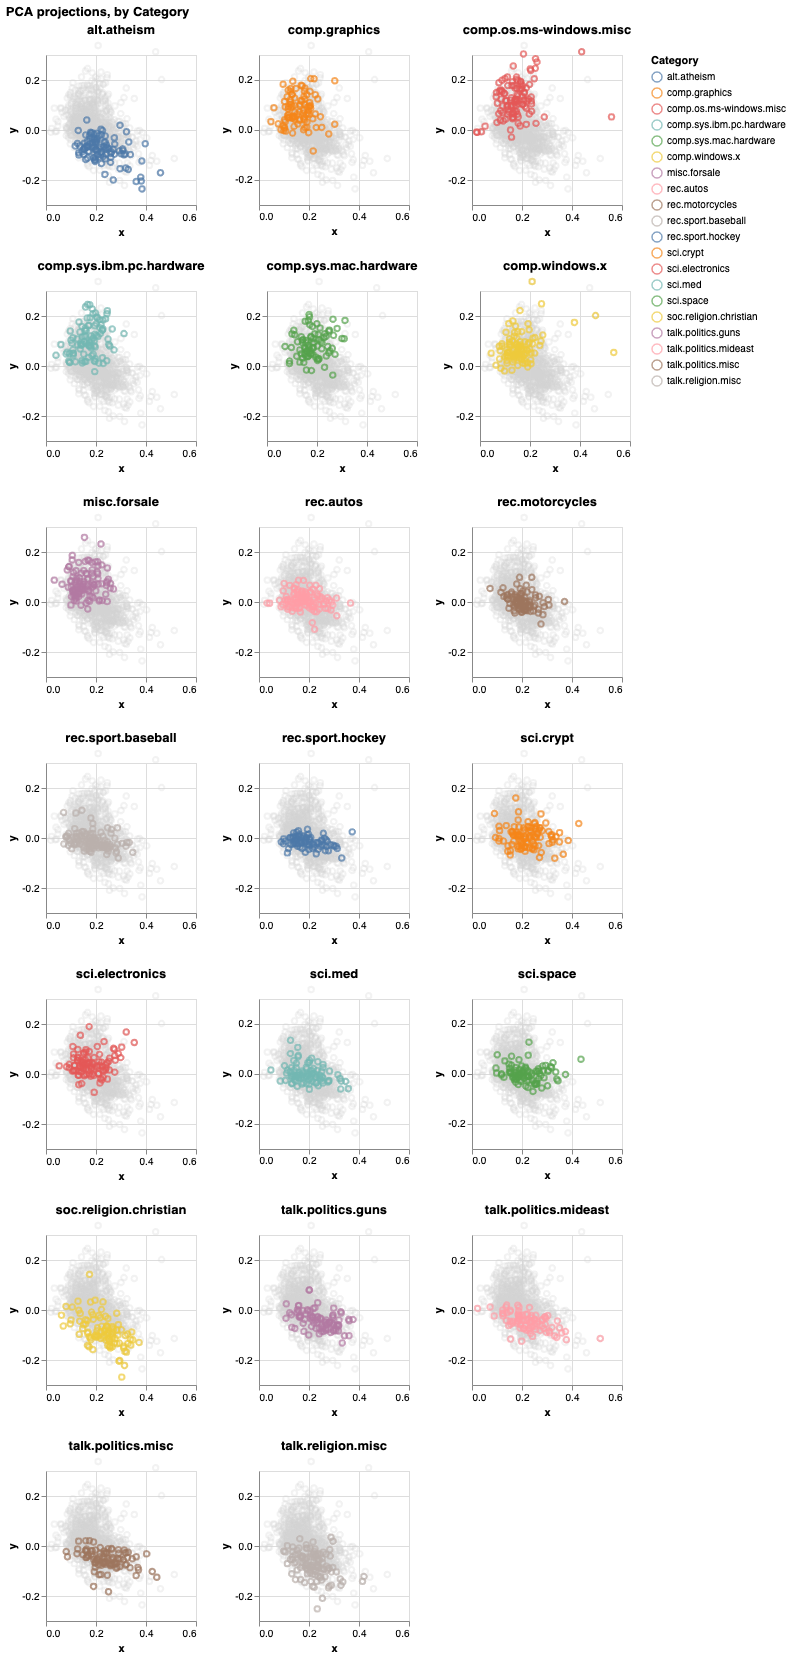

In [10]:
import altair as alt
from altair.expr import datum

data=plot_data.sample(2000)

base = alt.Chart(data).mark_point().encode(
    alt.X('x', scale=alt.Scale(domain=(0, 0.6))),
    alt.Y('y', scale = alt.Scale(domain = (-0.3, 0.3))),
    color='Category:N'
)

## Make gray points for background
chart1 = alt.Chart(data.sample(1000)) \
            .encode(x="x", y="y") \
            .mark_point(opacity=0.3, color="lightgray")


def overlay_make_chart(base_chart, category, options, chart1):
    title = category
    chart2 = base_chart\
      .transform_filter(datum.Category == category)\
      .properties(width=options['width'], 
                    height=options['height'], title=title)
    chart = chart1 + chart2
    return chart


options = {'width': 150, 'height': 150}
charts = [overlay_make_chart(base, category, options, chart1) \
          for category in sorted(data.Category.unique())]

# make a single row
def make_chart_row(row_of_charts):
    hconcat = [chart for chart in row_of_charts]
    row = alt.HConcatChart(hconcat=hconcat)
    return row

# take an array of charts and produce a facet grid
def facet_wrap(charts, charts_per_row):
    rows_of_charts = [
        charts[i:i+charts_per_row] 
        for i in range(0, len(charts), charts_per_row)]        
    vconcat = [make_chart_row(r) for r in rows_of_charts]    
    vcc = alt.VConcatChart(vconcat=vconcat)\
      .configure_axisX(grid=True)\
      .configure_axisY(grid=True)
    return vcc

# assemble the facet grid
compound_chart = facet_wrap(charts, charts_per_row=3)
compound_chart.properties(title='PCA projections, by Category')

In [12]:
!pip install pendulum

In [ ]:
##okay good - looks better. 

In [ ]:
from sklearn.pipeline import Pipeline 

BUCKETS=2048
hv = HashingVectorizer(norm=None, token_pattern='(?u)\\b[A-Za-z]\\w+\\b', stop_words ='english', n_features=BUCKETS, alternate_sign = False)
tfidf = TfidfTransformer()
feat_pipeline = Pipeline([('vect',hv), ('tfidf',tfidf)])

In [ ]:
training_vecs = feat_pipeline.fit_transform(training_data["Text"])

In [ ]:
from xgboost import XGBClassifier

In [ ]:
pip install xgboost

In [ ]:
%%time

XGB_TREE_METHOD='hist'
xgb = XGBClassifier(tree_method=XGB_TREE_METHOD, 
                    # num_parallel_tree=16, 
                    n_estimators=100, 
                    max_depth=3, 
                    colsample_bynode=0.3, 
                    colsample_bytree=0.3, 
                    subsample=1, 
                    reg_alpha=1)

xgb.fit(training_vecs, training_data["Category"])

In [ ]:
xgb.score(training_vecs, training_data["Category"])

In [ ]:
testing_data = pd.read_parquet('/Users/sowatson/dev/py-archeology/testing.parquet')
testing_vecs=feat_pipeline.transform(testing_data["Message"])
xgb.score(testing_vecs, testing_data["Category"])

In [ ]:
from mlworkflows import plot

df, chart =plot.confusion_matrix(testing_data["Category"], xgb.predict(testing_vecs))

In [ ]:
chart

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(testing_data["Category"], xgb.predict(testing_vecs)))

In [ ]:
from mlworkflows import util

util.serialize_to(xgb, "model.sav")

In [ ]:
pip install cloudpickle

In [ ]:
from mlworkflows import util

util.serialize_to(xgb, "model.sav")